In [2]:
from mads_datasets.base import BaseDatastreamer
from mltrainer.preprocessors import BasePreprocessor
from pathlib import Path
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch import nn
import torch

from src import datasets, metrics

In [14]:
import tomllib

datadir = Path('../data')
configfile = Path("config.toml")

with configfile.open('rb') as f:
    config = tomllib.load(f)
print(config)

{'ptb': 'heart', 'arrhythmia': 'heart_big'}


In [15]:
#trainfile = datadir / (config['arrhythmia'] + '_train.parq')
trainfile = datadir / (config['arrhythmia'] + '_oversampled_full_train.parq')
testfile = datadir / (config['arrhythmia'] + '_test.parq')
trainfile, testfile
# load data in dataframes
train_df = pd.read_parquet(trainfile)
test_df = pd.read_parquet(testfile)
shape = (16, 12)
traindataset = datasets.HeartDataset2D(trainfile, target="target", shape=shape)
testdataset = datasets.HeartDataset2D(testfile, target="target", shape=shape)
x, y = traindataset[20]
x.shape, y

(PosixPath('../data/heart_big_oversampled_full_train.parq'),
 PosixPath('../data/heart_big_test.parq'))

In [20]:
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
    print("Using MPS")
else:
    device = "cpu"

traindataset.to(device)
testdataset.to(device)


Using MPS


In [48]:
#Load the datastreamers
trainstreamer = BaseDatastreamer(traindataset, preprocessor = BasePreprocessor(), batchsize=32)
teststreamer = BaseDatastreamer(testdataset, preprocessor = BasePreprocessor(), batchsize=32)
print(len(trainstreamer), len(teststreamer))
x, y = next(trainstreamer.stream())
x.shape, y.shape

8593 684


(torch.Size([32, 1, 16, 12]), torch.Size([32]))

The ConvBlock makes it easier to stack block in the model.
Feel free to experiment with other architectures here:
- adding ideas like resnet, googlenet, squeeze-excite, etc.
- add additional layers like dropout, batchnorm, etc.
- experiment with different ways to go from 4D to 2D tensors

In [36]:
import torch
import torch.nn as nn
#ResNet block consists of two convolutional layers, batch normalization, and a ReLU activation, with a skip connection from the input to the output.
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Identity shortcut connection, could be a 1x1 convolution to match dimensions
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)  # Add the shortcut (skip connection)
        out = self.relu(out)
        return out

In [24]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
    def forward(self, x):
        return self.conv(x)

In [53]:
from src import models
config = {
    'hidden' : 128,
    'num_blocks' : 1,
    'num_classes' : 5,
    'shape' : shape,

}
print(config)
model = models.CNN(config)
model.to(device)
model(x).shape

2025-01-21 08:32:39.435 | INFO     | src.models:__init__:37 - Activation map size: 48
2025-01-21 08:32:39.436 | INFO     | src.models:__init__:38 - Input linear: 6144


{'hidden': 128, 'num_blocks': 1, 'num_classes': 5, 'shape': (16, 12)}


torch.Size([32, 5])

In [25]:
import torch
class CNN(nn.Module):
    def __init__(self, config: dict) -> None:
        super().__init__()
        hidden = config['hidden']
        self.convolutions = nn.ModuleList([
            ConvBlock(1, hidden),
        ])

        for i in range(config['num_blocks']):
            self.convolutions.extend([ConvBlock(hidden, hidden), nn.ReLU()])
        self.convolutions.append(nn.MaxPool2d(2, 2))

        self.dense = nn.Sequential(
            nn.Flatten(),
            nn.Linear((8*6) * hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, config['num_classes']),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for conv in self.convolutions:
            x = conv(x)
        x = self.dense(x)
        return x

In [38]:
class CNNWithResNet(nn.Module):
    def __init__(self, config: dict) -> None:
        super().__init__()
        hidden = config['hidden']
        
        # Start with an initial convolutional block
        self.convolutions = nn.ModuleList([
            nn.Conv2d(1, hidden, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(hidden)
        ])
        
        # Adding multiple ResNet blocks
        for i in range(config['num_blocks']):
            self.convolutions.append(ResNetBlock(hidden, hidden))
        
        # MaxPool at the end of convolutions
        self.convolutions.append(nn.MaxPool2d(2, 2))

        # Fully connected (dense) layers
        self.dense = nn.Sequential(
            nn.Flatten(),
            nn.Linear((8*6) * hidden, hidden),  # Adjust the size according to your image dimensions
            nn.ReLU(),
            nn.Linear(hidden, config['num_classes']),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for layer in self.convolutions:
            x = layer(x)
        x = self.dense(x)
        return x

In [54]:
from src import models
config = {
    'hidden' : 128,
    'num_blocks' : 1,
    'num_classes' : 5,
    'shape' : shape,

}
print(config)
model = CNNWithResNet(config)
model.to(device)
model(x).shape
model

{'hidden': 128, 'num_blocks': 1, 'num_classes': 5, 'shape': (16, 12)}


CNNWithResNet(
  (convolutions): ModuleList(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ResNetBlock(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dense): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=6144, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=5, bias=True)
  )
)

In [28]:
yhat = model(x)

The data is unbalanced, so we are interested in much more than just accuracy.

In [41]:
f1micro = metrics.F1Score(average='micro')
f1macro = metrics.F1Score(average='macro')
precision = metrics.Precision('micro')
recall = metrics.Recall('macro')
accuracy = metrics.Accuracy()

In [42]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mads_exam.db")
mlflow.set_experiment("2D conv with ResNet model")

2025/01/20 21:49:32 INFO mlflow.tracking.fluent: Experiment with name '2D conv with ResNet model' does not exist. Creating a new experiment.


<Experiment: artifact_location='/Users/francesca/code_repo/MADS-exam-25/notebooks/mlruns/7', creation_time=1737406172964, experiment_id='7', last_update_time=1737406172964, lifecycle_stage='active', name='2D conv with ResNet model', tags={}>

In [43]:
# Check if MPS is available
if torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

In [44]:
classes = train_df.target.unique()
class_weights = compute_class_weight('balanced', classes=classes, y=train_df.target)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)

In [ ]:
#training with ResNet block, fully oversampled, and class rebalancing through class weights
from mltrainer import Trainer, TrainerSettings, ReportTypes

loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)

with mlflow.start_run():
    optimizer = torch.optim.Adam

    settings = TrainerSettings(
        epochs=15,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="logs/heart2D",
        train_steps=len(trainstreamer) // 5, #met 5 epochs heeft het een keer de hele dataset gezien
        valid_steps=len(teststreamer) // 5,
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs={"factor": 0.5, "patience": 2},
        earlystop_kwargs=None
    )

    # modify the tags when you change them!
    mlflow.set_tag("model", "Conv2D_ResNet")
    mlflow.set_tag("dataset", "heart_fully_oversampled_big_binary")
    mlflow.log_param("scheduler", "None")
    mlflow.log_param("earlystop", "None")

    mlflow.log_params(config)
    mlflow.log_param("epochs", settings.epochs)
    mlflow.log_param("shape0", shape[0])
    mlflow.log_param("optimizer", str(optimizer))
    mlflow.log_params(settings.optimizer_kwargs)

    trainer = Trainer(
        model=model,
        settings=settings,
        loss_fn=loss_fn,
        optimizer=optimizer,
        traindataloader=trainstreamer.stream(),
        validdataloader=teststreamer.stream(),
        scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau,
        )
    trainer.loop()

    #htop om de gpu te zien
    # dimensie transformer reduceren

2025-01-20 21:51:03.113 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to logs/heart2D/20250120-215103
100%|██████████| 1718/1718 [00:17<00:00, 100.01it/s]
2025-01-20 21:51:21.137 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.2502 test 0.2778 metric ['0.9076', '0.9076', '0.7150', '0.9076', '0.9161']
100%|██████████| 1718/1718 [00:16<00:00, 102.59it/s]
2025-01-20 21:51:38.685 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.1000 test 0.1767 metric ['0.9467', '0.9467', '0.8003', '0.9467', '0.9436']
100%|██████████| 1718/1718 [00:16<00:00, 101.75it/s]
2025-01-20 21:51:56.378 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.0707 test 0.1197 metric ['0.9644', '0.9644', '0.8506', '0.9644', '0.9435']
100%|██████████| 1718/1718 [00:17<00:00, 98.28it/s]
2025-01-20 21:52:14.666 | INFO     | mltrainer.trainer:report:191 - Epoch 3 train 0.0551 test 0.0966 metric ['0.9733', '0.9733', '0.8815', '0.9733', '0.9406']
100%|██████████| 1718/1718 [00:17<0

{'hidden': 128, 'num_blocks': 1, 'num_classes': 5, 'shape': (16, 12)}
test_results=[0.993 0.821 0.957 0.82  0.991]


[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'Target')]

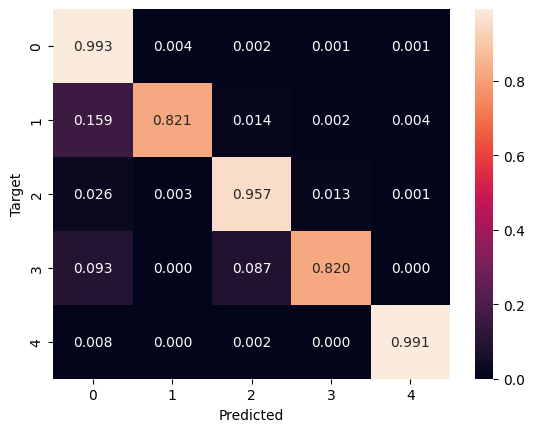

In [46]:
import seaborn as sns
import numpy as np

y_true = []
y_pred = []

testdata = teststreamer.stream()
for _ in range(len(teststreamer)):
    X, y = next(testdata)
    yhat = model(X)
    yhat = yhat.argmax(dim=1) # we get the one with the highest probability
    y_pred.append(yhat.cpu().tolist())
    y_true.append(y.cpu().tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)
print(config)
print(f'test_results={np.round(cfm[cfm > 0.3], 3)}')
plot = sns.heatmap(cfm, annot=cfm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")

In [ ]:
#training with class rebalancing through class weights
from mltrainer import Trainer, TrainerSettings, ReportTypes

loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)

with mlflow.start_run():
    optimizer = torch.optim.Adam

    settings = TrainerSettings(
        epochs=15,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="logs/heart2D",
        train_steps=len(trainstreamer) // 5, #met 5 epochs heeft het een keer de hele dataset gezien
        valid_steps=len(teststreamer) // 5,
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs={"factor": 0.5, "patience": 2},
        earlystop_kwargs=None
    )

    # modify the tags when you change them!
    mlflow.set_tag("model", "Conv2D")
    mlflow.set_tag("dataset", "heart_big_binary")
    mlflow.log_param("scheduler", "None")
    mlflow.log_param("earlystop", "None")

    mlflow.log_params(config)
    mlflow.log_param("epochs", settings.epochs)
    mlflow.log_param("shape0", shape[0])
    mlflow.log_param("optimizer", str(optimizer))
    mlflow.log_params(settings.optimizer_kwargs)

    trainer = Trainer(
        model=model,
        settings=settings,
        loss_fn=loss_fn,
        optimizer=optimizer,
        traindataloader=trainstreamer.stream(),
        validdataloader=teststreamer.stream(),
        scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau,
        )
    trainer.loop()

    #htop om de gpu te zien
    # dimensie transformer reduceren

2025-01-20 21:38:07.592 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to logs/heart2D/20250120-213807
100%|██████████| 1718/1718 [00:15<00:00, 113.76it/s]
2025-01-20 21:38:23.862 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.3390 test 0.4397 metric ['0.8559', '0.8559', '0.6275', '0.8559', '0.8982']
100%|██████████| 1718/1718 [00:14<00:00, 122.19it/s]
2025-01-20 21:38:38.638 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.1226 test 0.1511 metric ['0.9490', '0.9490', '0.7868', '0.9490', '0.9455']
100%|██████████| 1718/1718 [00:14<00:00, 121.59it/s]
2025-01-20 21:38:53.610 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.0857 test 0.2136 metric ['0.9343', '0.9343', '0.7581', '0.9343', '0.9347']
100%|██████████| 1718/1718 [00:14<00:00, 119.95it/s]
2025-01-20 21:39:08.760 | INFO     | mltrainer.trainer:report:191 - Epoch 3 train 0.0625 test 0.1492 metric ['0.9563', '0.9563', '0.8423', '0.9563', '0.9570']
100%|██████████| 1718/1718 [00:14<

{'hidden': 128, 'num_blocks': 1, 'num_classes': 5, 'shape': (16, 12)}
test_results=[0.983 0.829 0.963 0.855 0.977]


[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'Target')]

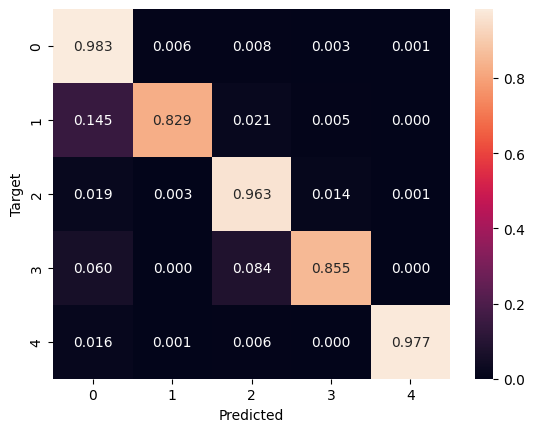

In [34]:
import seaborn as sns
import numpy as np

y_true = []
y_pred = []

testdata = teststreamer.stream()
for _ in range(len(teststreamer)):
    X, y = next(testdata)
    yhat = model(X)
    yhat = yhat.argmax(dim=1) # we get the one with the highest probability
    y_pred.append(yhat.cpu().tolist())
    y_true.append(y.cpu().tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)
print(config)
print(f'test_results={np.round(cfm[cfm > 0.3], 3)}')
plot = sns.heatmap(cfm, annot=cfm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")

[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'Target')]

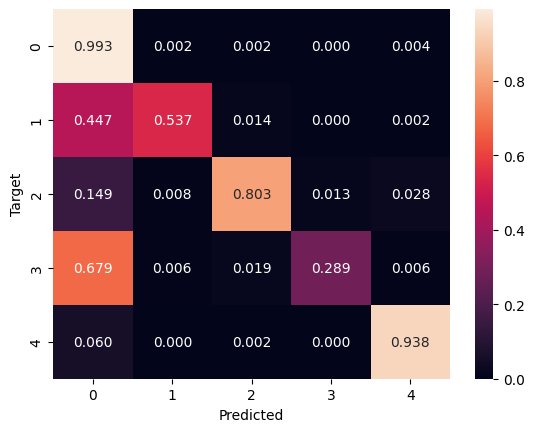

In [ ]:
import seaborn as sns
import numpy as np

y_true = []
y_pred = []

testdata = teststreamer.stream()
for _ in range(len(teststreamer)):
    X, y = next(testdata)
    yhat = model(X)
    yhat = yhat.argmax(dim=1) # we get the one with the highest probability
    y_pred.append(yhat.cpu().tolist())
    y_true.append(y.cpu().tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)

plot = sns.heatmap(cfm, annot=cfm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")

In [22]:
from src import models
config = {
    'hidden' : 32,
    'num_blocks' : 2,
    'num_classes' : 5,
    'shape' : shape,

}
model = models.CNN(config)
model.to(device)
model(x).shape

2025-01-15 21:34:11.075 | INFO     | src.models:__init__:37 - Activation map size: 48
2025-01-15 21:34:11.075 | INFO     | src.models:__init__:38 - Input linear: 1536


torch.Size([32, 5])

In [25]:
# training with oversampled data
from mltrainer import Trainer, TrainerSettings, ReportTypes
loss_fn = torch.nn.CrossEntropyLoss()

with mlflow.start_run():
    optimizer = torch.optim.Adam

    settings = TrainerSettings(
        epochs=5,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="logs/heart2D",
        train_steps=len(trainstreamer) // 5, #met 5 epochs heeft het een keer de hele dataset gezien
        valid_steps=len(teststreamer) // 5,
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs=None,
        earlystop_kwargs=None
    )

    # modify the tags when you change them!
    mlflow.set_tag("model", "Conv2D")
    mlflow.set_tag("dataset", "heart_small_binary")
    mlflow.log_param("scheduler", "None")
    mlflow.log_param("earlystop", "None")

    mlflow.log_params(config)
    mlflow.log_param("epochs", settings.epochs)
    mlflow.log_param("shape0", shape[0])
    mlflow.log_param("optimizer", str(optimizer))
    mlflow.log_params(settings.optimizer_kwargs)

    trainer = Trainer(
        model=model,
        settings=settings,
        loss_fn=loss_fn,
        optimizer=optimizer,
        traindataloader=trainstreamer.stream(),
        validdataloader=teststreamer.stream(),
        scheduler=None,
        )
    trainer.loop()

    #htop om de gpu te zien
    # dimensie transformer reduceren

2025-01-16 09:46:22.537 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to logs/heart2D/20250116-094622
100%|██████████| 547/547 [00:05<00:00, 104.05it/s]
2025-01-16 09:46:28.401 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.4959 test 0.2791 metric ['0.9216', '0.9216', '0.6519', '0.9216', '0.6592']
100%|██████████| 547/547 [00:05<00:00, 104.97it/s]
2025-01-16 09:46:34.234 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.2230 test 0.1938 metric ['0.9458', '0.9458', '0.7502', '0.9458', '0.7444']
100%|██████████| 547/547 [00:05<00:00, 104.66it/s]
2025-01-16 09:46:40.075 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.1701 test 0.1553 metric ['0.9596', '0.9596', '0.8009', '0.9596', '0.8059']
100%|██████████| 547/547 [00:05<00:00, 104.50it/s]
2025-01-16 09:46:45.919 | INFO     | mltrainer.trainer:report:191 - Epoch 3 train 0.1526 test 0.1541 metric ['0.9568', '0.9568', '0.7908', '0.9568', '0.8047']
100%|██████████| 547/547 [00:05<00:00, 104

In [ ]:
def confusion_matrix(X, y):
    y_true = []
    y_pred = []
    yhat = model(X)
    yhat = yhat.argmax(dim=1) # we get the one with the highest probability
    y_pred.append(yhat.cpu().tolist())
    y_true.append(y.cpu().tolist())

    yhat = [x for y in y_pred for x in y]
    y = [x for y in y_true for x in y]

    cfm = confusion_matrix(y, yhat)
    cfm = cfm / np.sum(cfm, axis=1, keepdims=True)

    return cfm

[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'Target')]

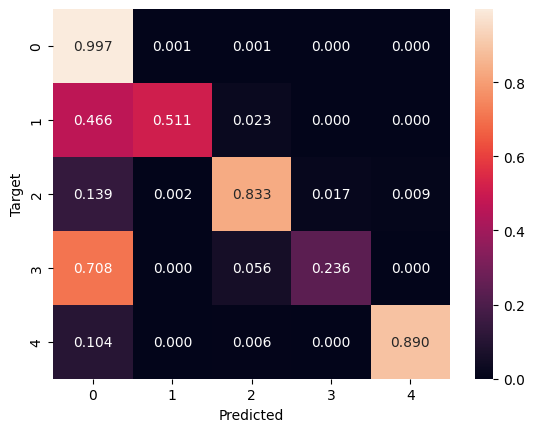

In [26]:
y_true = []
y_pred = []

testdata = teststreamer.stream()
for _ in range(len(teststreamer)):
    X, y = next(testdata)
    yhat = model(X)
    yhat = yhat.argmax(dim=1) # we get the one with the highest probability
    y_pred.append(yhat.cpu().tolist())
    y_true.append(y.cpu().tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)

plot = sns.heatmap(cfm, annot=cfm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")